In [1]:
# Import PyTorch Data Loader Library
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.models.segmentation import fcn_resnet50, fcn_resnet101
from torchvision import transforms

# Other Library Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchmetrics
from torchmetrics import Dice
import resource
from monai.losses import DiceLoss as MonaiDiceLoss
from monai.networks.nets import UNet
from sklearn.model_selection import train_test_split

# Custom Imports
from DRAC_Dataloading import DRAC_Loader
from DRAC_Models import ResNetBinary
from DRAC_Training import train_model
from DRAC_Testing import test_model
from DRAC_Criterion import DiceLoss
from models_unetpp import UNetPlusPlus

# Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
torch.__version__

'2.0.1'

In [3]:
torchmetrics.__version__

'1.3.2'

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA RTX A5000


In [5]:
def current_memory_usage():
    return resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024

In [6]:
## Default Variables ##
# Datasets #


# Dataloader #
batch_size = 16 # Batch size of 16

# Model #
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
).to(device)
model_name = 'UNet-Monai'

criterion = MonaiDiceLoss(sigmoid=True)
criterion_name = 'MonaiDice'

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 200

print(current_memory_usage())

902.375


In [7]:
# Use os to list all items in following directory
directory = "./data/Segmentation/Original/train/"
items = os.listdir(directory)

# Item Locations
item_locations = [directory + item for item in items]

# Split the data into training and validation sets
train_items, val_items = train_test_split(items, test_size=0.2, random_state=42)

In [8]:
# Now make full list with directories
train_items_full = [directory + item for item in train_items]
val_items_full = [directory + item for item in val_items]

In [9]:
# In validation of items, check to see if each item is in various labels in the following locations:
intraretinal_dir = "./data/Segmentation/Groundtruths/intraretinal/"
neovascular_dir = "./data/Segmentation/Groundtruths/neovascular/"
nonperfusion_dir = "./data/Segmentation/Groundtruths/nonperfusion/"

# Cycle through each item in both train_items, find train_items and val_items in the 3 directories for each item, as long as the item is in the train_items or val_items
train_items_intraretinal = [intraretinal_dir + item for item in train_items if item in os.listdir(intraretinal_dir)]
train_items_neovascular = [neovascular_dir + item for item in train_items if item in os.listdir(neovascular_dir)]
train_items_nonperfusion = [nonperfusion_dir + item for item in train_items if item in os.listdir(nonperfusion_dir)]

val_items_intraretinal = [intraretinal_dir + item for item in val_items if item in os.listdir(intraretinal_dir)]
val_items_neovascular = [neovascular_dir + item for item in val_items if item in os.listdir(neovascular_dir)]
val_items_nonperfusion = [nonperfusion_dir + item for item in val_items if item in os.listdir(nonperfusion_dir)]

# Now only give the names of the items, not the full path, for each fo the masks.
train_items_intraretinal_name = [item.split("/")[-1] for item in train_items_intraretinal]
train_items_neovascular_name = [item.split("/")[-1] for item in train_items_neovascular]
train_items_nonperfusion_name = [item.split("/")[-1] for item in train_items_nonperfusion]

val_items_intraretinal_name = [item.split("/")[-1] for item in val_items_intraretinal]
val_items_neovascular_name = [item.split("/")[-1] for item in val_items_neovascular]
val_items_nonperfusion_name = [item.split("/")[-1] for item in val_items_nonperfusion]

In [10]:
transforms = transforms.Compose([
    transforms.ToTensor()
])

In [11]:
# Make a list of datasets
train_datasets = [DRAC_Loader(data = train_items_full, data_names = train_items, labels_loc = train_items_intraretinal, label_names = train_items_intraretinal_name, data_type = 'train', mask = "intraretinal", transform=transforms, rotation = False),
                  DRAC_Loader(data = train_items_full, data_names = train_items, labels_loc = train_items_neovascular, label_names = train_items_neovascular_name, data_type = 'train', mask = "neovascular", transform=transforms, rotation = False),
                  DRAC_Loader(data = train_items_full, data_names = train_items, labels_loc = train_items_nonperfusion, label_names = train_items_nonperfusion_name, data_type = 'train', mask = "nonperfusion", transform=transforms, rotation = False)]

val_datasets = [DRAC_Loader(data = val_items_full, data_names = val_items, labels_loc = val_items_intraretinal, label_names = val_items_intraretinal_name, data_type = 'val', mask = "intraretinal", transform=transforms, rotation = False),
                DRAC_Loader(data = val_items_full, data_names = val_items, labels_loc = val_items_neovascular, label_names = val_items_neovascular_name, data_type = 'val', mask = "neovascular", transform=transforms, rotation = False),
                DRAC_Loader(data = val_items_full, data_names = val_items, labels_loc = val_items_nonperfusion, label_names = val_items_nonperfusion_name, data_type = 'val', mask = "nonperfusion", transform=transforms, rotation = False)]

In [12]:
train_dataloaders = [DataLoader(train_datasets[0], batch_size=batch_size, shuffle=True),
                     DataLoader(train_datasets[1], batch_size=batch_size, shuffle=True),
                     DataLoader(train_datasets[2], batch_size=batch_size, shuffle=True)]

val_dataloaders = [DataLoader(val_datasets[0], batch_size=batch_size, shuffle=True),
                     DataLoader(val_datasets[1], batch_size=batch_size, shuffle=True),
                     DataLoader(val_datasets[2], batch_size=batch_size, shuffle=True)]

In [13]:
# Print the length of all datasets
len(train_datasets[0]), len(val_datasets[0]), len(train_datasets[1]), len(val_datasets[1]), len(train_datasets[2]), len(val_datasets[2])

(87, 22, 87, 22, 87, 22)

In [14]:
# Look at image dimension in dataset
image, mask = train_datasets[0][0]
image.shape, mask.shape

(torch.Size([1, 1024, 1024]), torch.Size([1, 1024, 1024]))

In [15]:
loader_names = ['Intraretinal', 'Neovascularization', 'Nonperfusion']

folder = f'models/{model_name}_{batch_size}_{epochs}_{criterion_name}'

def createModelFolder(directory):
    # Check to see if the folder exists, if not, create it. If it does, cycle through number interations until a new folder is created.
    if not os.path.exists(directory):
        os.makedirs(directory)
    else:
        i = 1
        while os.path.exists(f'{directory}_{i}'):
            i += 1
        folder = f'{directory}_{i}'
        os.makedirs(directory)
# Create the folder
all_losses = []
count = 0
create = True

for i in range(3):
    statistics = train_model(model, train_dataloaders[i], val_dataloaders[i], criterion, optimizer, epochs=epochs, criterion_name=criterion_name, segmentation_name=loader_names[i])

    if create:
        # Check first to see if folder does not exist
        if not os.path.exists(folder):
            createModelFolder(folder)
        
        create = False
    
    # Save in the folder
    torch.save(model.state_dict(), f'{folder}/model_{loader_names[i]}.pt')
    
    # Append the "statistics" item to the all_losses list
    all_losses.append(statistics)

Epoch: 1/200 | Training Loss: 0.9865 | Validation Loss: 0.9827 | Time: 1.04 seconds
Epoch: 2/200 | Training Loss: 0.9802 | Validation Loss: 0.9750 | Time: 0.76 seconds
Epoch: 3/200 | Training Loss: 0.9758 | Validation Loss: 0.9610 | Time: 0.75 seconds
Epoch: 4/200 | Training Loss: 0.9751 | Validation Loss: 0.9664 | Time: 0.76 seconds
Epoch: 5/200 | Training Loss: 0.9721 | Validation Loss: 0.9595 | Time: 0.74 seconds
Epoch: 6/200 | Training Loss: 0.9715 | Validation Loss: 0.9646 | Time: 0.75 seconds
Epoch: 7/200 | Training Loss: 0.9688 | Validation Loss: 0.9649 | Time: 0.76 seconds
Epoch: 8/200 | Training Loss: 0.9678 | Validation Loss: 0.9573 | Time: 0.77 seconds
Epoch: 9/200 | Training Loss: 0.9643 | Validation Loss: 0.9594 | Time: 0.77 seconds
Epoch: 10/200 | Training Loss: 0.9637 | Validation Loss: 0.9531 | Time: 0.77 seconds
Epoch: 11/200 | Training Loss: 0.9603 | Validation Loss: 0.9577 | Time: 0.76 seconds
Epoch: 12/200 | Training Loss: 0.9553 | Validation Loss: 0.9584 | Time: 0.

In [16]:
stat1 = all_losses[0]

# Load "train_loss" from the statistics.
train_loss1 = stat1['train_loss']

# Load the "valid_loss" from the statistics.
valid_loss1 = stat1['valid_loss']

train_loss1

[0.9864753672186812,
 0.9802213361253028,
 0.9757674359915551,
 0.9750718208026417,
 0.9721461307569426,
 0.9715493095452784,
 0.9687772847805762,
 0.9677547032535655,
 0.9642943575124349,
 0.9636625476334513,
 0.9602538613566761,
 0.9553015157843857,
 0.9506823698733234,
 0.9421787436992309,
 0.9437878704201866,
 0.9350057268472636,
 0.9336178240534748,
 0.9176084715280118,
 0.9059229048502068,
 0.8999671205702665,
 0.8829878552859638,
 0.8779495092025179,
 0.8619554781626212,
 0.8532094718583328,
 0.8185404428048124,
 0.8072019887646001,
 0.795407182660338,
 0.7728265943593922,
 0.7482302007184586,
 0.7406028756701891,
 0.710642359032072,
 0.6939759956977273,
 0.6617024737792584,
 0.6459173146269136,
 0.6150595084374952,
 0.5980022823550954,
 0.5704801784424081,
 0.5311309720681809,
 0.5319405089685023,
 0.5116021135514798,
 0.5005567530738005,
 0.4898066319409647,
 0.4911575386727564,
 0.4503415866269003,
 0.4621320874103114,
 0.4516874051512269,
 0.4413784989181702,
 0.444987705583

In [17]:
# Checks to see if graphs folder exists #
if not os.path.exists('graphs'):
    os.makedirs('graphs')

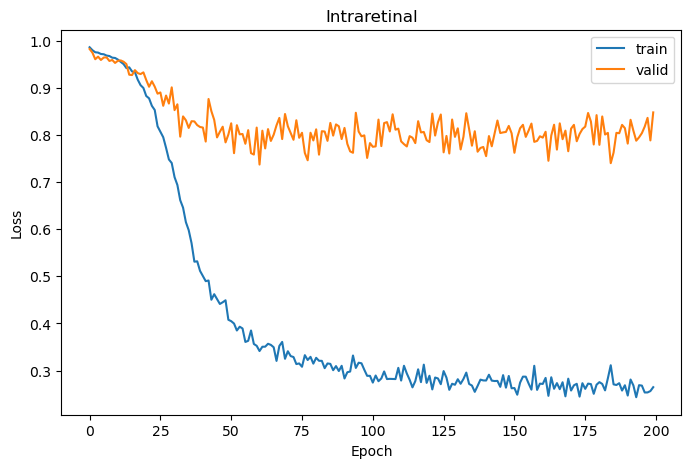

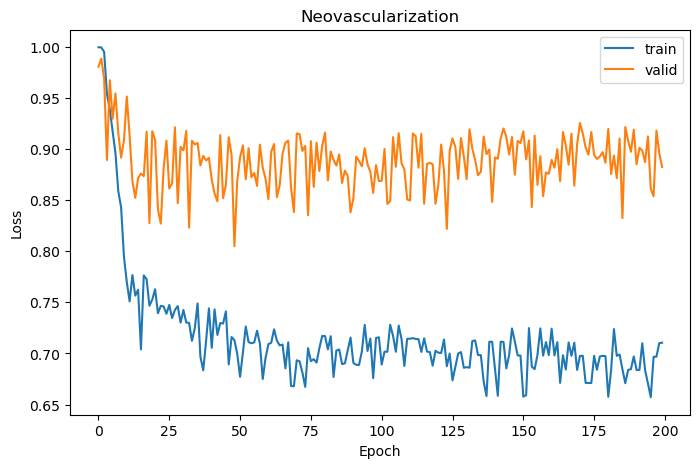

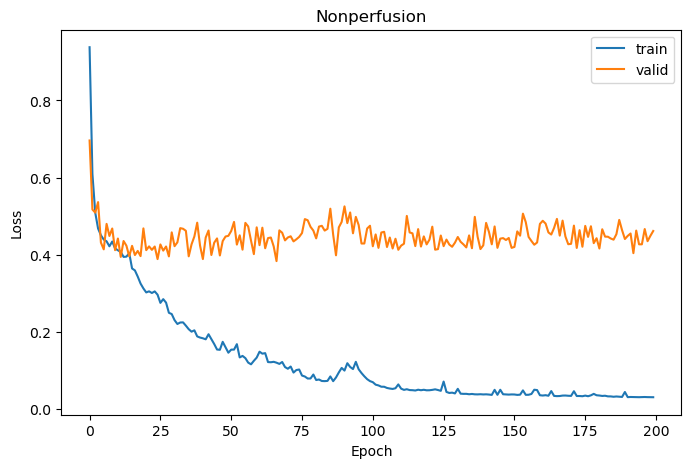

In [18]:
# Plot the loss
plot = True
count = 0
graph_folder = f'graphs/{model_name}_{batch_size}_{epochs}_{criterion_name}'
savegraphs = True

# If graph folder does not exist, create
if not os.path.exists(graph_folder):
    os.makedirs(graph_folder)

for stats in all_losses:
    # Create 3 subplots loading "train_loss" and "valid_loss" on each subplot, with title being loader_names[count]
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.plot(stats['train_loss'], label='train')
    ax.plot(stats['valid_loss'], label='valid')
    ax.set_title(loader_names[count])
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    if savegraphs: plt.savefig(f'{graph_folder}/{loader_names[count]}_loss.png')
    plt.show()
    count += 1